# Coursera Capstone Project

## The Battle of Neighbourhoods - Final Report (Week 1 and 2)

## 1. Introduction and Business Problem

### Project Background

London is an ever-growing city, the most populated in the United Kingdom. It has a wide diversity being made up of many groups of different cultures; as well as being the financial capital of the UK. It is a global hub of business and commerce. The city is a major center for banking and finance, retailing, world trade, transportation, tourism, real estate, new media, traditional media, advertising, legal services, accountancy, insurance, theater, fashion, and the arts in the UK.


### Project Description

This project aims to find a suitable hotel based on location, price and venues. In order to make a comparison and evaluation of the hotel options in London, I have set a basis, therefore the apartment in London must meet the following requirements:

The hotel will have 2 beds in 1 room for 2 adults and 1 child. The price of rent not exceed £1,700 during the stay. It must be desirable to have venues such as cafés/coffeeshops, Indian restaurant, food shops.

### Target Audience
The target audience for this will be aimed at those (either internal or external migrants) visiting London wanting to stay close to its many types of venues. In this particular project it focuses on a family of three.

## 2.  Data Section

### Description of the data and its sources that will be used to solve the problem.

How the data will be used to solve the problem:

Data will be extracted from Wikipedia's table using the beautiful soup library: https://en.wikipedia.org/wiki/London_boroughs

London has several boroughs and neighbourhoods. To segment and the explore the neighbourhoods, a dataset will be created that has each borough and neighbourhood.

Geocoder will be used to obtain a list of latitudes and longitudes for each borough. As well as a list of hotels in London area with their addresses and price acquired from https://www.expedia.ie/Hotel-Search?GOTO=HOTSEARCH&SearchArea=City&SearchType=Place&adults=2&children=1_13&destination=London%20%28and%20vicinity%29%2C%20England%2C%20United%20Kingdom&endDate=2021-08-13&lang=2057&latLong=&needUTF8Decode=true&regionId=178279&rfrr=hotel.search&selected=&semdtl=&sort=RECOMMENDED&startDate=2021-08-10&theme=&useRewards=false&userIntent= .

Then after modifications, information gathered will be input through FourSquare API and geopy data to retrive information on London's most common venues of selected boroughs and neighbourhoods. As well as map the location of rental places, in some form, linked to the venues. Addresses from rental locations will be converted to geodata(lat, long) using Geopy-distance and Nominatim.

## 3.  Methodology

### Upload the necessary libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!pip install lxml

!pip install bs4
from bs4 import BeautifulSoup

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Libraries imported.')

     |████████████████████████████████| 122kB 34.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.2.0                |     pyhd8ed1ab_0          67 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         102 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.2.0-pyhd8ed1ab_0



geographiclib-1.52   | 35 

### Scrape Neighbourhood Data

In [88]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_London_boroughs'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [89]:
BoroughName = []
Coordinates = []

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if len(cells) > 0:
        BoroughName.append(cells[0].text.rstrip('\n'))
        Coordinates.append(cells[8].text.rstrip('\n'))

In [90]:
# Form a dataframe
dict = {'BoroughName' : BoroughName,
       'Coordinates': Coordinates}
info = pd.DataFrame.from_dict(dict)
info.head()

,BoroughName,Coordinates
0,Barking and Dagenham[note 1],51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [91]:
# Strip unwanted texts
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(']'))
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip('1234567890.'))
info['BoroughName'] = info['BoroughName'].str.replace('note','')
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(' ['))
info.head()

,BoroughName,Coordinates
0,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [92]:
# Clean coordinates
info[['Coordinates1','Coordinates2','Coordinates3']] = info['Coordinates'].str.split('/',expand=True)
info.head()

,BoroughName,Coordinates,Coordinates1,Coordinates2,Coordinates3
0,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...,51°33′39″N 0°09′21″E﻿,﻿51.5607°N 0.1557°E﻿,51.5607; 0.1557﻿ (Barking and Dagenham)
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...,51°37′31″N 0°09′06″W﻿,﻿51.6252°N 0.1517°W﻿,51.6252; -0.1517﻿ (Barnet)
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...,51°27′18″N 0°09′02″E﻿,﻿51.4549°N 0.1505°E﻿,51.4549; 0.1505﻿ (Bexley)
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...,51°33′32″N 0°16′54″W﻿,﻿51.5588°N 0.2817°W﻿,51.5588; -0.2817﻿ (Brent)
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...,51°24′14″N 0°01′11″E﻿,﻿51.4039°N 0.0198°E﻿,51.4039; 0.0198﻿ (Bromley)


In [93]:
info.drop(labels=['Coordinates','Coordinates1','Coordinates2'], axis=1,inplace = True)
info[['Latitude','Longitude']] = info['Coordinates3'].str.split(';',expand=True)
info.head()

,BoroughName,Coordinates3,Latitude,Longitude
0,Barking and Dagenham,51.5607; 0.1557﻿ (Barking and Dagenham),51.5607,0.1557﻿ (Barking and Dagenham)
1,Barnet,51.6252; -0.1517﻿ (Barnet),51.6252,-0.1517﻿ (Barnet)
2,Bexley,51.4549; 0.1505﻿ (Bexley),51.4549,0.1505﻿ (Bexley)
3,Brent,51.5588; -0.2817﻿ (Brent),51.5588,-0.2817﻿ (Brent)
4,Bromley,51.4039; 0.0198﻿ (Bromley),51.4039,0.0198﻿ (Bromley)


In [94]:
info.drop(labels=['Coordinates3'], axis=1,inplace = True)
info['Latitude'] = info['Latitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Latitude'] = info['Latitude'].map(lambda x: x.lstrip())
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(')'))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(' ('))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Longitude'] = info['Longitude'].map(lambda x: x.lstrip())
info.head()

,BoroughName,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198


In [95]:
info['BoroughName'].unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype=object)

###  Foursquare API

List of top 50 popular places in the neighbourhood

source: Foursquare    

url: https://api.foursquare.com

In [96]:
CLIENT_ID = 'IFF5DMVUSHG3SITNEP5JBOB5JRG1BHXXDZWZVGA3Q5BHNIXQ' # your Foursquare ID
CLIENT_SECRET = 'ONDDUPCJOHXXDQZFZSV00CZ4NPOIIENNHQZRYXGBQGUDKGRO' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IFF5DMVUSHG3SITNEP5JBOB5JRG1BHXXDZWZVGA3Q5BHNIXQ
CLIENT_SECRET:ONDDUPCJOHXXDQZFZSV00CZ4NPOIIENNHQZRYXGBQGUDKGRO


In [97]:
#Create a function to explore all borough
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['BoroughName', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [98]:
#Get top 50 venues in 500m radius of the center of each Borough
LIMIT = 50
venues = getNearbyVenues(names=info['BoroughName'],
                                   latitudes=info['Latitude'],
                                   longitudes=info['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [99]:
print(venues.shape)
venues.head()

(1134, 7)


,BoroughName,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket
2,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
3,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts School
4,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center


### Let's check how many venues were returned for each neighborhood

In [100]:
venues.groupby('BoroughName').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
BoroughName,,,,,,
Barking and Dagenham,7,7,7,7,7,7
Barnet,5,5,5,5,5,5
Bexley,27,27,27,27,27,27
Brent,50,50,50,50,50,50
Bromley,37,37,37,37,37,37
Camden,50,50,50,50,50,50
Croydon,37,37,37,37,37,37
Ealing,50,50,50,50,50,50
Enfield,50,50,50,50,50,50


### Let's find out how many unique categories can be curated from all the returned venues

In [101]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 185 uniques categories.


### Analyze Each Neighbourhood

In [102]:
# one hot encoding
london_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['BoroughName'] = venues['BoroughName'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,BoroughName,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Currency Exchange,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lighting Store,Liquor Store,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Mall,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shopping Mall,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Strip Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### And let's examine the new dataframe size.

In [103]:
london_onehot.shape

(1134, 186)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [104]:
london_grouped = london_onehot.groupby('BoroughName').mean().reset_index()
london_grouped

,BoroughName,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Currency Exchange,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lighting Store,Liquor Store,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Mall,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shopping Mall,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Strip Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00000,0.000000,0.000000,0.142857,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.142857,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.142857,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.142857,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.00000,0.00,0.00000,0.000000,0.00,0.00,0.000000,0.142857,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00

### Let's print each neighborhood along with the top 5 most common venues

In [105]:
num_top_venues = 5

for hood in london_grouped['BoroughName']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['BoroughName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
         venue  freq
0  Bus Station  0.14
1         Pool  0.14
2  Supermarket  0.14
3  Golf Course  0.14
4         Park  0.14


----Barnet----
                        venue  freq
0                        Café   0.4
1                    Bus Stop   0.2
2  Construction & Landscaping   0.2
3                Home Service   0.2
4          African Restaurant   0.0


----Bexley----
                  venue  freq
0           Coffee Shop  0.11
1        Clothing Store  0.11
2                   Pub  0.11
3           Supermarket  0.07
4  Fast Food Restaurant  0.07


----Brent----
                 venue  freq
0          Coffee Shop  0.10
1                Hotel  0.10
2       Clothing Store  0.06
3        Grocery Store  0.06
4  Sporting Goods Shop  0.06


----Bromley----
            venue  freq
0  Clothing Store  0.16
1     Coffee Shop  0.14
2     Pizza Place  0.05
3             Bar  0.05
4    Burger Joint  0.05


----Camden----
         venue  freq
0        Hotel  0.12
1   

In [14]:
# function that extracts the category of the venue - MERGE THESE TWO WITH ABOVE???????
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

### Let's put that into a pandas dataframe

#### First, let's write a function to sort the venues in descending order.

In [118]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [119]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['BoroughName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['BoroughName'] = london_grouped['BoroughName']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Golf Course,Pool,Bus Station,Supermarket,Gym / Fitness Center,Park,Martial Arts School,English Restaurant,Fish Market,Fish & Chips Shop
1,Barnet,Café,Construction & Landscaping,Bus Stop,Home Service,Yoga Studio,Escape Room,Food Court,Flea Market,Fish Market,Fish & Chips Shop
2,Bexley,Coffee Shop,Pub,Clothing Store,Supermarket,Fast Food Restaurant,Pharmacy,Plaza,Italian Restaurant,Furniture / Home Store,Department Store
3,Brent,Hotel,Coffee Shop,Clothing Store,Sporting Goods Shop,Grocery Store,American Restaurant,Sandwich Place,Bar,Restaurant,Stadium
4,Bromley,Clothing Store,Coffee Shop,Pizza Place,Burger Joint,Bar,Chocolate Shop,Furniture / Home Store,Café,Fast Food Restaurant,Sandwich Place


In [120]:
kclusters = 5
london_cluster = london_grouped.drop('BoroughName', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_cluster)

kmeans.labels_[0:10]

array([1, 0, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [125]:
# add clustering labels

neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto coords to add latitude/longitude for each neighborhood
london_merged = info
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('BoroughName'), on='BoroughName')

london_merged.head()

,BoroughName,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,51.5607,0.1557,1,Golf Course,Pool,Bus Station,Supermarket,Gym / Fitness Center,Park,Martial Arts School,English Restaurant,Fish Market,Fish & Chips Shop
1,Barnet,51.6252,-0.1517,0,Café,Construction & Landscaping,Bus Stop,Home Service,Yoga Studio,Escape Room,Food Court,Flea Market,Fish Market,Fish & Chips Shop
2,Bexley,51.4549,0.1505,4,Coffee Shop,Pub,Clothing Store,Supermarket,Fast Food Restaurant,Pharmacy,Plaza,Italian Restaurant,Furniture / Home Store,Department Store
3,Brent,51.5588,-0.2817,4,Hotel,Coffee Shop,Clothing Store,Sporting Goods Shop,Grocery Store,American Restaurant,Sandwich Place,Bar,Restaurant,Stadium
4,Bromley,51.4039,0.0198,4,Clothing Store,Coffee Shop,Pizza Place,Burger Joint,Bar,Chocolate Shop,Furniture / Home Store,Café,Fast Food Restaurant,Sandwich Place


In [133]:
address = 'London, UK'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.5073219 -0.1276474


In [134]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7)
       
        
map_clusters

TypeError: must be real number, not str

In [129]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Barnet,Café,Construction & Landscaping,Bus Stop,Home Service,Yoga Studio,Escape Room,Food Court,Flea Market,Fish Market,Fish & Chips Shop


In [82]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Golf Course,Pool,Bus Station,Supermarket,Gym / Fitness Center,Park,Martial Arts School,English Restaurant,Fish Market,Fish & Chips Shop
13,Harrow,Indian Restaurant,Grocery Store,Coffee Shop,Supermarket,Thai Restaurant,Platform,Indie Movie Theater,Home Service,Eastern European Restaurant,Fish Market
21,Lewisham,Supermarket,Coffee Shop,Grocery Store,Italian Restaurant,Train Station,Platform,Greek Restaurant,Shopping Mall,Bus Stop,Pub
22,Merton,Supermarket,Café,Irish Pub,Italian Restaurant,Grocery Store,Garden Center,Fast Food Restaurant,Park,Pizza Place,Coffee Shop
24,Redbridge,Grocery Store,Supermarket,Fast Food Restaurant,Clothing Store,Hotel,Sandwich Place,Turkish Restaurant,Coffee Shop,Bakery,Irish Pub


In [83]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Hounslow,Indian Restaurant,Fast Food Restaurant,Café,Restaurant,Park,Yoga Studio,English Restaurant,Flea Market,Fish Market,Fish & Chips Shop


In [84]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Newham,Hotel,Airport Service,Sandwich Place,Airport Lounge,Pharmacy,Currency Exchange,Rafting,Chinese Restaurant,Yoga Studio,English Restaurant


In [85]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bexley,Coffee Shop,Pub,Clothing Store,Supermarket,Fast Food Restaurant,Pharmacy,Plaza,Italian Restaurant,Furniture / Home Store,Department Store
3,Brent,Hotel,Coffee Shop,Clothing Store,Sporting Goods Shop,Grocery Store,American Restaurant,Sandwich Place,Bar,Restaurant,Stadium
4,Bromley,Clothing Store,Coffee Shop,Pizza Place,Burger Joint,Bar,Chocolate Shop,Furniture / Home Store,Café,Fast Food Restaurant,Sandwich Place
5,Camden,Hotel,Café,Coffee Shop,Pub,Bakery,Train Station,Breakfast Spot,Pizza Place,Museum,Chocolate Shop
6,Croydon,Pub,Asian Restaurant,Korean Restaurant,Portuguese Restaurant,Coffee Shop,Café,Mediterranean Restaurant,Bus Stop,Caribbean Restaurant,Strip Club
7,Ealing,Coffee Shop,Italian Restaurant,Park,Pub,Clothing Store,Pizza Place,Vietnamese Restaurant,Hotel,Burger Joint,Department Store
8,Enfield,Clothing Store,Coffee Shop,Optical Shop,Supermarket,Café,Pub,Pharmacy,Gift Shop,Video Game Store,Department Store
9,Greenwich,Pub,Coffee Shop,Supermarket,Clothing Store,Grocery Store,Fast Food Restaurant,Pharmacy,Platform,Plaza,Hotel
10,Hackney,Pub,Coffee Shop,Cocktail Bar,Brewery,Bakery,Grocery Store,Modern European Restaurant,Café,Organic Grocery,Vegetarian / Vegan Restaurant
11,Hammersmith and Fulham,Pub,Italian Restaurant,Indian Restaurant,Café,Gastropub,Vietnamese Restaurant,Clothing Store,Japanese Restaurant,Coffee Shop,French Restaurant


In [39]:
address = 'London, UK'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.5073219 -0.1276474


In [135]:

map_clusters = folium.Map(location=[51.5073219, -0.1276474], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
                                 
                                            

TypeError: must be real number, not str

In [32]:
ldnhotel_data = pd.read_csv('LondonHotels.csv') 
ldnhotel_data.head()

,ID,Name,Address,Borough,Postcode,Reviews,Price for 3 Nights (£),Lat,Long
0,0,DoubleTree by Hilton London Angel Kings Cross,60 Pentonville Road,Islington,N1 9LA,4.2,217,NaN,NaN
1,1,Ibis Budget London Hounslow,20-28 Staines Road,Hounslow,TW3 3JS,3.5,104,NaN,NaN
2,2,Treehouse Hotel London,"Langham Place, Regent Street",Westminster,W1B 2QS,4.4,1046,NaN,NaN
3,3,The Resident Covent Garden,51 Bedford Street,Westminster,WC2R 0PZ,4.9,668,NaN,NaN
4,4,The Trafalgar St. James London,"2 Spring Gardens, Trafalgar Square",Westminster,SW1A 2TS,4.7,713,NaN,NaN


In [33]:
ldnhotel_data.tail()

,ID,Name,Address,Borough,Postcode,Reviews,Price for 3 Nights (£),Lat,Long
66,66,"The Waldorf Hilton, London",Aldwych,Westminster,WC2B 4DD,4.2,852,NaN,NaN
67,67,Radisson Blu Edwardian Bloomsbury Street Hotel,"9-13 Bloomsbury Street, Bloomsbury",Camden,WC1B 3QD,4.3,483,NaN,NaN
68,68,The Piccadilly London West End,"65-73 Shaftesbury Avenue, Piccadilly",Westminster,W1D 6EX,4.1,901,NaN,NaN
69,69,Flemings Mayfair,"7-12 Half Moon Street, Mayfair",Westminster,W1J 7BH,4.3,1046,NaN,NaN
70,70,Hampton by Hilton London Waterloo,"157 Waterloo Road, Waterloo",Lambeth,SE1 8XA,4.4,346,NaN,NaN


In [35]:
ldnhotel_data.drop(labels=['ID'], axis=1,inplace = True)

### Obtain geodata ( lat,long) for each hotel in London with Nominatim

#### Data was stored in a csv file for simplifaction report purposes and saving code processing time in future.

In [41]:
## This section may be 'markedown' for the report because its execution takes few minutes .
## Terefore, the csv previusly made may be just read directly.   

for n in range(len(ldnhotel_data)):   
    address= ldnhotel_data['Postcode'][n]
    address=(ldnhotel_data['Postcode'][n]+ '  , '+' London UK ')
    geolocator = Nominatim(user_agent="Dáibhéid")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    ldnhotel_data['Lat'][n]=latitude
    ldnhotel_data['Long'][n]=longitude
    #print(n,latitude,longitude)
    time.sleep(2)

print('Geodata completed')
# save dataframe to csv file
ldnhotel_data.to_csv('ldnhotel_latlong.csv',index=False)
ldnhotel_data.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


AttributeError: 'NoneType' object has no attribute 'latitude'

In [ ]:
ldnhotel_data=pd.read_csv('ldnhotel_latlong.csv')
ldnhotel_data.head(70)

## London hotel price statistics

<AxesSubplot:xlabel='Price for 3 Nights (£)'>

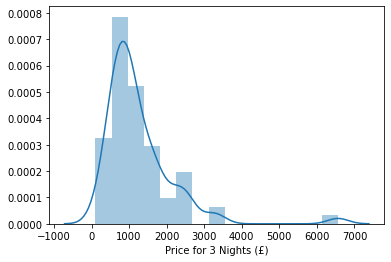

In [36]:
import seaborn as sns
sns.distplot(ldnhotel_data['Price for 3 Nights (£)'],bins=15)

<AxesSubplot:xlabel='Reviews'>

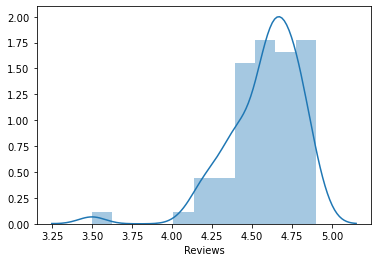

In [39]:
sns.distplot(ldnhotel_data['Reviews'],bins=11)

<AxesSubplot:xlabel='Reviews', ylabel='Price for 3 Nights (£)'>

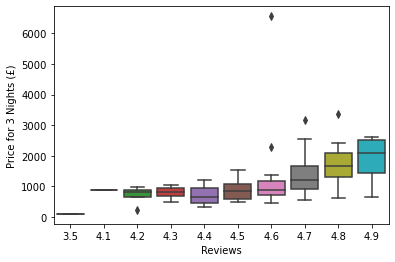

In [42]:
sns.boxplot(x='Reviews', y= 'Price for 3 Nights (£)', data=ldnhotel_data)

## Map of London hotels

The popups will indicate the address and the price thus making it convenient to select the target hotel with the price condition estipulated (max £1700)

In [40]:
# create map of London using latitude and longitude values from Nominatim
latitude= 51.5073219
longitude= -0.1276474

map_london_hotel = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(ldnhotel_data['Lat'], ldnhotel_data['Long'],'$ ' + ldnhotel_data['Price for 3 Nights (£)'].astype(str)+ ',  '+ ldnhotel_data['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_hotel) 
    

map_london_hotel

ValueError: Location values cannot contain NaNs, got:
[nan, nan]

## Map of London showing the places to stay and the cluster of venues

### Now, one can point to a rental place for price and address location information while knowing the cluster venues around it.
### This is an insightful way to explore hotel possibilites

In [40]:
# create map of London using latitude and longitude values from Nominatim
latitude= 51.5073219
longitude= -0.1276474

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for rental places
for lat, lng, label in zip(ldnhotel_data['Lat'], ldnhotel_data['Long'],'$ ' + ldnhotel_data['Price for 3 Nights (£)'].astype(str)+ ldnhotel_data['Postcode']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_london_hotel.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_london_hotel)

map_clusters2

TypeError: must be real number, not str